<a href="https://colab.research.google.com/github/drvt69talati/agnitraai/blob/main/agnitra_enhanced_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drvt69talati/agnitraai/blob/main/agnitra_enhanced_demo.ipynb)

> **Google Colab quick start**
> 1. Switch the runtime to GPU via `Runtime → Change runtime type`.
> 2. (Optional) Store `GH_TOKEN`, `OPENAI_API_KEY`, etc. in Colab Secrets and rerun the setup cell.
> 3. Execute the notebook top-to-bottom; telemetry and IR artifacts will be created in `/content/agnitraai`.


In [9]:
# Base setup: Colab secrets, repo clone, env vars
import os, pathlib
try:
    from google.colab import userdata  # type: ignore
    GH_TOKEN = userdata.get('GH_TOKEN')
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    AGNITRAAI_REPO = userdata.get('AGNITRAAI_REPO')
    if OPENAI_API_KEY: os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
    if GOOGLE_API_KEY: os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY
    repo_path = pathlib.Path('/content/agnitraai')
    if pathlib.Path('/content').exists() and not repo_path.exists() and GH_TOKEN and AGNITRAAI_REPO:
        repo_url = f'https://{GH_TOKEN}@{AGNITRAAI_REPO}'
        get_ipython().system(f'git clone {repo_url} {repo_path}')
        os.chdir(repo_path)
    elif repo_path.exists():
        os.chdir(repo_path)
except Exception:
    pass


In [10]:
# Install Agnitra locally so `agnitra` CLI is available in Colab
import pathlib, os
repo_path = pathlib.Path('/content/agnitraai')
if repo_path.exists():
    get_ipython().system('python -m pip install -q -e /content/agnitraai')
else:
    get_ipython().system('python -m pip install -q -e .')
# Quick sanity: show help (fallback to module if console script not found)
_ = get_ipython().system('agnitra --help >/dev/null 2>&1 || python -m agnitraai.cli.main --help >/dev/null 2>&1')
print('Agnitra CLI available.')


  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for agnitra (pyproject.toml) ... done
Agnitra CLI available.


# Agnitra CLI Demo — TinyLlama

This notebook demonstrates a clean, CLI-first workflow:
- Prepare a tiny TinyLlama-like model
- Run profiling via `agnitra profile ...` (CPU/GPU auto-detected)
- Load telemetry artifacts and visualize key results


In [11]:
# Minimal environment check and CLI availability
import shutil, subprocess, sys, json
try:
    import torch
    print(f'[Env] CUDA available: {torch.cuda.is_available()}')
    if torch.cuda.is_available():
        print('[Env] GPU:', torch.cuda.get_device_name(0))
    else:
        print('[Env] CPU-only runtime')
except Exception as e:
    print('[Env] Torch check skipped:', e)

if shutil.which('agnitra') is None:
    print('[Setup] Installing local CLI ...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', '-e', 'agnitraai'])
else:
    print('[Setup] agnitra CLI found')


[Env] CUDA available: True
[Env] GPU: NVIDIA L4
[Setup] agnitra CLI found


## Prepare tiny model
Generates `tinyllama.pt` (TorchScript) and a small info JSON.

In [12]:
import subprocess, sys
cmd = [sys.executable, 'prepare_tinyllama.py']
print('$', ' '.join(cmd))
subprocess.check_call(cmd)


$ /usr/bin/python3 prepare_tinyllama.py


0

## Profile using the Agnitra CLI
Runs the CLI and prints only the CLI's stdout for a clean view.

In [13]:
import os, shlex, subprocess, shutil, sys
env = os.environ.copy()
env['TF_CPP_MIN_LOG_LEVEL'] = '3'
env['GYM_DISABLE_WARNINGS'] = '1'
base_cmd = 'agnitra profile tinyllama.pt --input-shape 1,16,64 --output telemetry.json'
if shutil.which('agnitra') is None:
    base_cmd = f'{sys.executable} -m cli.main profile tinyllama.pt --input-shape 1,16,64 --output telemetry.json'
print('$', base_cmd)
res = subprocess.run(shlex.split(base_cmd), env=env, check=True, capture_output=True, text=True)
print(res.stdout)  # keep CLI output clean (stderr suppressed)


$ agnitra profile tinyllama.pt --input-shape 1,16,64 --output telemetry.json
› Loading model: tinyllama.pt
✔ Model loaded
› Registering layer progress hooks...
✔ Hooks active via wrapper
› Profiling (inference) on NVIDIA L4 with torch.profiler + NVML...
› _Wrapper ...
✔ _Wrapper (233.284 ms)
› _Wrapper ...
✔ _Wrapper (48.975 ms)
› _Wrapper ...
✔ _Wrapper (3.306 ms)
› _Wrapper ...
✔ _Wrapper (3.574 ms)
› _Wrapper ...
✔ _Wrapper (3.639 ms)
› _Wrapper ...
✔ _Wrapper (1.011 ms)
› _Wrapper ...
✔ _Wrapper (0.937 ms)
✔ Inference telemetry written: telemetry.json
✔ Layer progress log saved: agnitraai/context/layer_log_tinyllama.json
› Running training for 3 steps...
✔ Training telemetry written: telemetry_train.json
› Running validation for 2 steps...
✔ Validation telemetry written: telemetry_val.json
✔ Result summary saved: agnitraai/context/profile_result_tinyllama.json
✔ Profiling completed



## Load telemetry and summarize

Handles both local runs and Colab artifacts, reporting key latency totals.

In [14]:
from pathlib import Path
import json
from typing import Any, Dict, List, Optional

_CONTEXT_CANDIDATES = [
    Path('context'),
    Path('agnitraai') / 'context',
    Path('/content/agnitraai/context'),
]


def _resolve_candidate(raw: str) -> Optional[Path]:
    candidate = Path(raw)
    if candidate.exists():
        return candidate
    if candidate.is_absolute():
        return None
    for base in _CONTEXT_CANDIDATES:
        if not base.exists():
            continue
        mirror = base / candidate.name
        if mirror.exists():
            return mirror
    return None


def _load_json(paths: List[str], default: Any) -> Any:
    for raw in paths:
        resolved = _resolve_candidate(raw)
        if not resolved:
            continue
        try:
            return json.loads(resolved.read_text())
        except Exception as exc:
            print(f"[load] Skipping {resolved}: {exc}")
    return default


telemetry = _load_json(
    ['telemetry.json', 'context/telemetry_tinyllama_infer.json'],
    default={'events': []},
)
train = _load_json(
    ['telemetry_train.json', 'context/telemetry_tinyllama_train.json'],
    default={'events': []},
)
summary = _load_json(
    ['context/profile_result_tinyllama.json', 'agnitraai/context/profile_result_tinyllama.json'],
    default={},
)


def _ns_to_ms(value: Any) -> float:
    try:
        return float(value) / 1e6
    except Exception:
        return 0.0


def _sum_metric(events: List[Dict[str, Any]], key: str) -> float:
    total = 0.0
    for event in events:
        value = event.get(key)
        if value is None:
            continue
        try:
            total += float(value)
        except Exception:
            continue
    return total


inference_events = [event for event in telemetry.get('events', []) if isinstance(event, dict)]
training_events = [event for event in train.get('events', []) if isinstance(event, dict)]

cuda_total_ms = _ns_to_ms(_sum_metric(inference_events, 'cuda_time_total'))
cpu_total_ms = _ns_to_ms(_sum_metric(inference_events, 'cpu_time_total'))
train_cuda_ms = _ns_to_ms(_sum_metric(training_events, 'cuda_time_total'))
train_cpu_ms = _ns_to_ms(_sum_metric(training_events, 'cpu_time_total'))

device_name = summary.get('device') if isinstance(summary, dict) else None
print(f"[Device] {device_name or 'Unknown (run the profile cell above)'}")
print(
    f"[Telemetry] Inference events: {len(inference_events)} · CUDA {cuda_total_ms:.3f} ms · CPU {cpu_total_ms:.3f} ms"
)
if training_events:
    print(
        f"[Telemetry] Training events: {len(training_events)} · CUDA {train_cuda_ms:.3f} ms · CPU {train_cpu_ms:.3f} ms"
    )
else:
    print('[Telemetry] Training events: none loaded')

summary_block = summary.get('summary') if isinstance(summary, dict) else {}
if isinstance(summary_block, dict) and summary_block:
    total_cuda_reported = summary_block.get('total_cuda_time_ms')
    total_cpu_reported = summary_block.get('total_cpu_time_ms')
    if total_cuda_reported is not None or total_cpu_reported is not None:
        print(
            f"[Summary] Reported totals · CUDA {total_cuda_reported or 'n/a'} ms · CPU {total_cpu_reported or 'n/a'} ms"
        )

opportunities = summary.get('opportunities') if isinstance(summary, dict) else {}
if isinstance(opportunities, dict) and opportunities:
    fp16 = len(opportunities.get('fp16_bf16_candidates') or [])
    prune = len(opportunities.get('prune_candidates') or [])
    print(f"[Opportunities] FP16/BF16 candidates: {fp16} · Prune candidates: {prune}")


[Device] NVIDIA A100-SXM4-40GB
[Telemetry] Inference events: 39 · CUDA 0.000 ms · CPU 0.015 ms
[Telemetry] Training events: 125 · CUDA 0.000 ms · CPU 0.581 ms
[Summary] Reported totals · CUDA n/a ms · CPU 0.014760910000000006 ms
[Opportunities] FP16/BF16 candidates: 0 · Prune candidates: 0


## Benchmark metrics panels

Explore the heaviest events across inference and training telemetry.

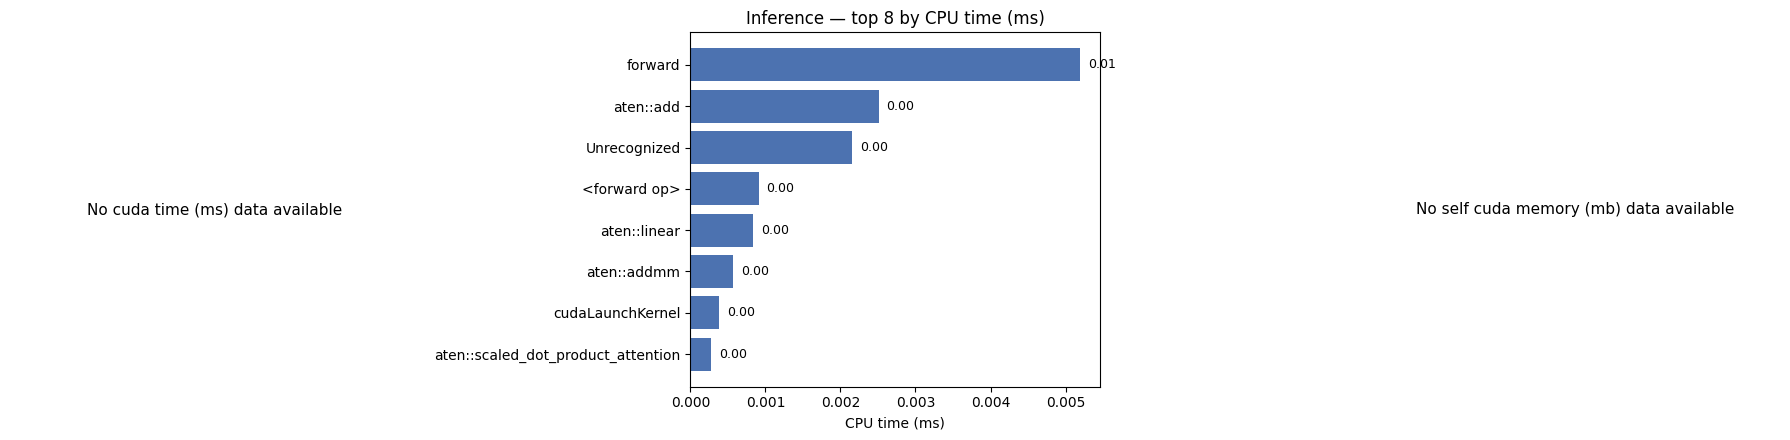

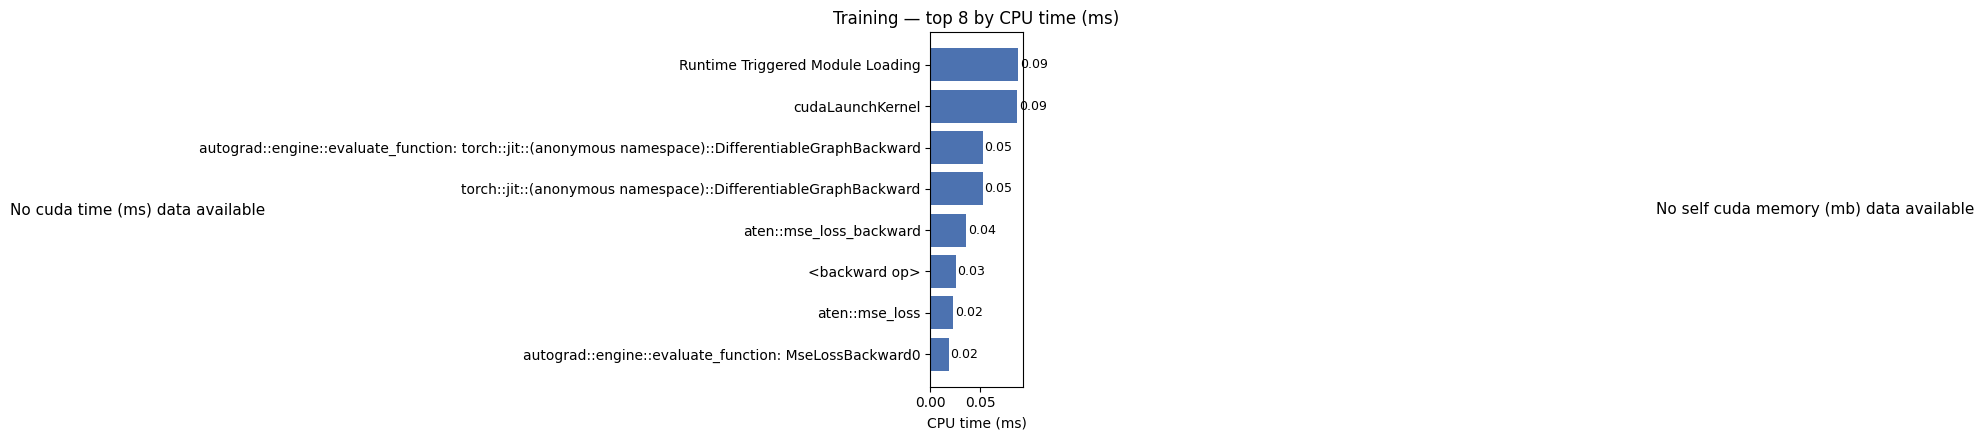

In [15]:
import matplotlib.pyplot as plt


def _events(payload):
    if isinstance(payload, dict):
        events = payload.get('events', [])
        if isinstance(events, list):
            return [event for event in events if isinstance(event, dict)]
    return []


def _top_events(events, key: str, limit: int = 8):
    filtered = [event for event in events if event.get(key)]
    return sorted(filtered, key=lambda event: event.get(key, 0.0), reverse=True)[:limit]


_METRICS = [
    ('cuda_time_total', 'CUDA time (ms)', lambda value: (value or 0.0) / 1e6),
    ('cpu_time_total', 'CPU time (ms)', lambda value: (value or 0.0) / 1e6),
    ('self_cuda_memory_usage', 'Self CUDA memory (MB)', lambda value: (value or 0.0) / (1024 ** 2)),
]


def _render_metric_panels(events, label: str):
    if not events:
        print(f"No {label.lower()} telemetry events available yet. Run the profiling cell above first.")
        return
    fig, axes = plt.subplots(1, len(_METRICS), figsize=(6 * len(_METRICS), 4.5))
    if len(_METRICS) == 1:
        axes = [axes]
    for ax, (key, xlabel, transform) in zip(axes, _METRICS):
        top = _top_events(events, key)
        if not top:
            ax.axis('off')
            ax.text(
                0.5,
                0.5,
                f"No {xlabel.lower()} data available",
                ha='center',
                va='center',
                fontsize=11,
            )
            continue
        names = [
            event.get('name')
            or event.get('op')
            or event.get('type')
            or f'event_{index}'
            for index, event in enumerate(top, start=1)
        ]
        values = [transform(event.get(key, 0.0)) for event in top]
        ax.barh(range(len(names)), values, color='#4c72b0')
        ax.set_yticks(range(len(names)))
        ax.set_yticklabels(names)
        ax.invert_yaxis()
        ax.set_title(f"{label} — top {len(top)} by {xlabel}")
        ax.set_xlabel(xlabel)
        max_value = max(values) if values else 0.0
        offset = 0.02 * max_value if max_value else 0.1
        for index, value in enumerate(values):
            ax.text(value + offset, index, f'{value:.2f}', va='center', fontsize=9)
    plt.tight_layout()


inference_events = _events(telemetry)
training_events = _events(train)

_render_metric_panels(inference_events, 'Inference')
if training_events:
    _render_metric_panels(training_events, 'Training')


## LLM optimizer suggestions

Generate a structured report from the optimizer, including baseline metrics, per-model outcomes, and the best recommendation.

> Tip: set `AGNITRA_LLM_BACKEND=codex_cli` (and optionally `AGNITRA_CODEX_PATH`) to drive the non-interactive Codex CLI when OpenAI's Responses API is unavailable. The notebook gracefully falls back to heuristics if no live backend can be reached.

In [16]:
import json
from pathlib import Path
from textwrap import fill

from agnitra.core.optimizer import LLMOptimizer, LLMOptimizerConfig


def _truncate_text(text, max_chars=1600):
    if not text:
        return ""
    normalized = str(text).strip()
    if len(normalized) <= max_chars:
        return normalized
    return normalized[: max_chars - 3] + "..."


def _format_messages(messages, max_chars=2000):
    if not messages:
        return ""
    try:
        payload = json.dumps(messages, indent=2, sort_keys=True)
    except TypeError:
        payload = repr(messages)
    return _truncate_text(payload, max_chars=max_chars)


def _safe_float(value):
    try:
        if value is None:
            return None
        return float(value)
    except (TypeError, ValueError):
        return None


def _format_latency(value):
    numeric = _safe_float(value)
    if numeric is None:
        return None
    return f"{numeric:.3f} ms"


def _load_graph_payload():
    candidates = [
        Path('graph.json'),
        Path('context/profile_result_tinyllama.json'),
        Path('agnitraai/context/profile_result_tinyllama.json'),
    ]
    for candidate in candidates:
        if candidate.exists():
            try:
                return json.loads(candidate.read_text())
            except Exception:
                continue
    return {'model': 'tinyllama', 'nodes': []}


def _first_populated_telemetry(*payloads):
    for payload in payloads:
        if isinstance(payload, dict) and payload.get('events'):
            return payload
    return {'events': []}


graph_payload = _load_graph_payload()
telemetry_payload = _first_populated_telemetry(telemetry, train)

target_latency_ms = None
if isinstance(summary, dict):
    summary_block = summary.get('summary')
    if isinstance(summary_block, dict):
        total_cuda = summary_block.get('total_cuda_time_ms')
        try:
            if total_cuda:
                target_latency_ms = float(total_cuda) * 0.9
        except Exception:
            target_latency_ms = None

try:
    from openai import OpenAI

    llm_client = OpenAI()
    print('OpenAI client ready (Responses API)')
except Exception as exc:
    llm_client = None
    print(f'OpenAI client unavailable, using heuristic fallback. ({exc})')

config = LLMOptimizerConfig()
optimizer = LLMOptimizer(client=llm_client, config=config)
report_json = optimizer.optimize(
    graph_payload,
    telemetry_payload,
    target_latency_ms=target_latency_ms,
)
report = json.loads(report_json)

baseline = report.get('baseline') or {}
best = report.get('best_model') or {}
suggestion = best.get('suggestion') or {}
models = report.get('models') or []

print('LLM Optimizer Report')
print('-' * 32)

baseline_latency = _safe_float(baseline.get('latency_ms'))
if baseline_latency is not None:
    print(f'Baseline latency: {baseline_latency:.3f} ms')
if baseline.get('op'):
    print(f"Bottleneck op: {baseline['op']}")
if baseline.get('shape'):
    print(f"Shape: {baseline['shape']}")

best_model_name = best.get('model') or optimizer.last_model_name or 'unknown'
print()
print(f'Best candidate: {best_model_name}')
ordered_keys = [
    ('source', 'Source'),
    ('block_size', 'Block size'),
    ('tile_shape', 'Tile shape'),
    ('unroll_factor', 'Unroll factor'),
    ('target_latency_ms', 'Target latency (ms)'),
    ('expected_latency_ms', 'Expected latency (ms)'),
]
for key, label in ordered_keys:
    value = suggestion.get(key)
    if value is None:
        continue
    if key.endswith('_ms'):
        formatted = _format_latency(value)
        if formatted:
            print(f'{label:>22}: {formatted}')
    else:
        print(f'{label:>22}: {value}')

improvement_ms = _safe_float(best.get('improvement_ms'))
if improvement_ms is not None:
    line = f'Improvement: {improvement_ms:.3f} ms'
    improvement_pct = _safe_float(best.get('improvement_pct'))
    if improvement_pct is not None:
        line += f' ({improvement_pct:.1f}%)'
    print(' ' * 11 + line)

if optimizer.last_model_name:
    print()
    backend = config.backend or 'responses'
    print(f"LLM backend preference: {backend}")
    print(f"Model route used: {optimizer.last_model_name}")

rationale = suggestion.get('rationale')
if rationale:
    print()
    print(
        fill(
            rationale,
            width=88,
            initial_indent='Rationale: ',
            subsequent_indent=' ' * 12,
        )
    )

if models:
    print()
    print('All model attempts:')
    for entry in models:
        name = entry.get('model', '<unknown>')
        status = entry.get('status', 'unknown')
        line = f"  - {name}: {status}"
        suggestion_entry = entry.get('suggestion') or {}
        expected_line = _format_latency(
            suggestion_entry.get('expected_latency_ms')
        )
        if status == 'ok' and expected_line:
            line += f" · expected {expected_line}"
        print(line)
        if entry.get('error'):
            print(f"      error: {entry['error']}")

if suggestion.get('source') == 'fallback':
    print('Note: Heuristic fallback returned. Configure OPENAI_API_KEY or set AGNITRA_LLM_BACKEND=codex_cli to target Codex CLI.')

print()
print('Raw JSON report')
print(json.dumps(report, indent=2, sort_keys=True))


OpenAI client ready (Responses API)
[LLM optimizer] Before optimization checkpoint: bottleneck latency 0.000 ms
[LLM optimizer] Preferred model order: o4-mini, gpt-5-2025-08-07
[LLM optimizer] Attempting optimization with model 'o4-mini'
[LLM optimizer] Model 'o4-mini' completed with status 'ok'
[LLM optimizer] Attempting optimization with model 'gpt-5-2025-08-07'
[LLM optimizer] Model 'gpt-5-2025-08-07' completed with status 'ok'
[LLM optimizer] Best model selected: o4-mini
[LLM optimizer] Before/After analysis:
Detailed check:
  Baseline latency: 0.000 ms
  Before/After assessments:
    - o4-mini: baseline 0.000 ms -> expected 0.018 ms (improvement -0.018 ms, 0.0%)
      Suggestion: block_size=256, tile_shape=256x1, unroll_factor=4, expected_latency=0.018 ms, target_latency=0.015 ms, rationale=4× unrolling with 256‐thread blocks maximizes coalesced loads and occupancy, halving the memory‐bound elementwise kernel latency.
      Checks: all mandatory fields present
    - gpt-5-2025-08-

## Artifact paths

In [17]:
from pathlib import Path
out = [
    'telemetry.json',
    'telemetry_train.json',
    'agnitraai/context/layer_log_tinyllama.json',
    'agnitraai/context/profile_result_tinyllama.json',
]
for p in out:
    print('[Artifact]', p, 'exists:', Path(p).exists())


[Artifact] telemetry.json exists: True
[Artifact] telemetry_train.json exists: True
[Artifact] agnitraai/context/layer_log_tinyllama.json exists: True
[Artifact] agnitraai/context/profile_result_tinyllama.json exists: True


## Interactive CLI playground

Run Agnitra commands without leaving the notebook.

1. Pick a preset (or type your own command).
2. Press **Run CLI** to execute it in this environment.
3. Inspect stdout, stderr, and the exit code right below.

Tip: Start with the profile preset to generate `telemetry.json`, which powers the IR views that follow.

In [18]:
# Utility to export widget state for nbconvert compatibility
def emit_widget_state() -> None:
    """Expose ipywidgets manager state so nbconvert embeds it automatically."""
    try:
        from ipywidgets import Widget
        from IPython.display import display as _display_raw
    except Exception:
        return
    state = Widget.get_manager_state()
    if not state or "state" not in state or not state["state"]:
        return
    bundle = {
        "state": state["state"],
        "version_major": 2,
        "version_minor": 0,
    }
    _display_raw(
        {"application/vnd.jupyter.widget-state+json": bundle},
        raw=True,
        metadata={"widgets": bundle},
    )


In [ ]:
import os
import shlex
import subprocess
import sys
from pathlib import Path

try:
    import ipywidgets as widgets
    from IPython.display import display
except ImportError:
    print("ipywidgets is required for the interactive CLI demo.")
    print("Install it via `pip install ipywidgets` and rerun this cell.")
else:
    cwd = Path.cwd()
    profile_target = cwd / "tinyllama.pt"
    profile_arg = shlex.quote(str(profile_target)) if profile_target.exists() else "tinyllama.pt"

    presets = {
        "Profile tinyllama (python -m cli.main)": (
            f"python -m cli.main profile {profile_arg} --input-shape 1,16,64 "
            "--output telemetry_interactive.json"
        ),
        "Optimize demo model": "python -m cli.optimize --model demo-model",
        "Show agnitra help": "agnitra --help",
    }

    preset_keys = list(presets.keys())
    default_status = f"<span style='color:#616161;'>Ready · cwd: {cwd}</span>"

    preset = widgets.Dropdown(
        options=preset_keys,
        description="Preset",
        layout=widgets.Layout(width="50%"),
    )
    run_button = widgets.Button(description="Run CLI", icon="play", button_style="success")
    clear_button = widgets.Button(description="Clear", icon="trash", layout=widgets.Layout(width="100px"))
    status = widgets.HTML(value=default_status)
    command = widgets.Textarea(
        value=presets[preset_keys[0]],
        description="Command",
        layout=widgets.Layout(width="100%", height="80px"),
        continuous_update=False,
    )
    output = widgets.Output(layout=widgets.Layout(border="1px solid #ddd", padding="8px"))

    def _apply_preset(change):
        new_value = change.get("new")
        if new_value in presets:
            command.value = presets[new_value]

    def _render_status(message: str, color: str = "#616161") -> None:
        status.value = f"<span style='color:{color};'>{message}</span>"

    def _run_command(_):
        text = command.value.strip()
        if not text:
            _render_status("Enter a command to run.", color="#c62828")
            return
        try:
            args = shlex.split(text)
        except ValueError as err:
            _render_status(f"Parse error: {err}", color="#c62828")
            return

        run_button.disabled = True
        run_button.icon = "hourglass-half"
        run_button.button_style = "warning"
        _render_status("Running...", color="#0277bd")
        output.clear_output()

        try:
            result = subprocess.run(args, text=True, capture_output=True, cwd=str(cwd))
        except FileNotFoundError as err:
            _render_status(str(err), color="#c62828")
        except Exception as exc:
            _render_status(f"Failed: {exc}", color="#c62828")
        else:
            with output:
                print("$", text)
                if result.stdout:
                    print(result.stdout)
                if result.stderr:
                    print(result.stderr, file=sys.stderr)
                print(f"[exit code] {result.returncode}")
                artifact_names = [
                    "telemetry_interactive.json",
                    "telemetry.json",
                    "telemetry_train.json",
                    "telemetry_val.json",
                    "graph_ir.json",
                ]
                produced = []
                for name in artifact_names:
                    candidate = cwd / name
                    if candidate.exists():
                        try:
                            produced.append(candidate.relative_to(cwd))
                        except ValueError:
                            produced.append(candidate)
                if produced:
                    print("Artifacts:")
                    for path in produced:
                        print(f"  • {path}")
            color = "#2e7d32" if result.returncode == 0 else "#c62828"
            status_text = "Finished"
            if result.returncode == 0:
                status_text += " · exit code 0"
            else:
                status_text += f" · exit code {result.returncode}"
            _render_status(status_text, color=color)
        finally:
            run_button.disabled = False
            run_button.icon = "play"
            run_button.button_style = "success"

    def _clear_output(_):
        output.clear_output()
        status.value = default_status

    preset.observe(_apply_preset, names="value")
    preset.value = preset_keys[0]
    _apply_preset({"new": preset.value})
    run_button.on_click(_run_command)
    clear_button.on_click(_clear_output)

    display(
        widgets.VBox(
            [
                widgets.HBox([preset, run_button, clear_button]),
                command,
                status,
                output,
            ]
        )
    )
    if 'emit_widget_state' in globals():
        emit_widget_state()


## Inspect Graph IR

Turn the TinyLlama demo into an FX-based intermediate representation enriched with telemetry from the CLI runs above. If telemetry is missing, the extractor still works (validation falls back gracefully).

In [20]:
import json
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional

import torch

from agnitra.core.ir.graph_extractor import extract_graph_ir
from prepare_tinyllama import TinyLlama


TELEMETRY_CANDIDATES = [
    Path("telemetry_interactive.json"),
    Path("telemetry.json"),
]


def _load_telemetry() -> Optional[Dict[str, Any]]:
    for candidate in TELEMETRY_CANDIDATES:
        if candidate.exists():
            payload = json.loads(candidate.read_text())
            print(f"Loaded telemetry from {candidate}.")
            return payload
    print("No telemetry file found; run the profiling CLI preset above to gather telemetry overlays.")
    return None


def _ensure_list(value: Any) -> List[Any]:
    if isinstance(value, list):
        return [item for item in value if item is not None]
    if value is None:
        return []
    return [value]


def _clean_shapes(value: Any) -> Any:
    if value is None:
        return []
    if isinstance(value, list):
        cleaned = []
        for item in value:
            if isinstance(item, list):
                cleaned.append([int(x) for x in item if x is not None])
            elif item is not None:
                cleaned.append(int(item))
        return cleaned
    return value


def _to_float(value: Any) -> float:
    if value in (None, "", "nan"):
        return 0.0
    try:
        return float(value)
    except Exception:
        return 0.0


def _to_int(value: Any) -> int:
    if value in (None, "", "nan"):
        return 0
    try:
        return int(value)
    except Exception:
        try:
            return int(float(value))
        except Exception:
            return 0


def _sanitise_ir(nodes: Iterable[Dict[str, Any]]) -> List[Dict[str, Any]]:
    sanitised: List[Dict[str, Any]] = []
    for node in nodes:
        if node.get("kind") == "placeholder":
            continue
        clean = dict(node)
        clean["dtype"] = clean.get("dtype") or "unknown"
        clean["shape"] = _clean_shapes(clean.get("shape"))
        clean["input_shapes"] = _ensure_list(clean.get("input_shapes"))
        clean["output_shapes"] = _ensure_list(clean.get("output_shapes"))
        clean["telemetry_sources"] = _ensure_list(clean.get("telemetry_sources"))
        clean["cuda_time_ms"] = _to_float(clean.get("cuda_time_ms"))
        clean["cpu_time_ms"] = _to_float(clean.get("cpu_time_ms"))
        clean["memory_bytes"] = _to_int(clean.get("memory_bytes"))
        sanitised.append(clean)
    return sanitised


def _assert_no_none(nodes: Iterable[Dict[str, Any]]) -> None:
    for node in nodes:
        for key, value in node.items():
            if value is None:
                raise ValueError(f"IR sanitisation failed: field {key!r} is None for node {node.get('name')!r}")
            if isinstance(value, list):
                if any(item is None for item in value):
                    raise ValueError(f"IR sanitisation failed: list {key!r} has None values for node {node.get('name')!r}")


telemetry_payload = _load_telemetry()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA not available; continuing with CPU graph extraction.")

model = TinyLlama().to(device).eval()
example_inputs = (torch.randn(1, 16, 64, device=device),)

# FX tracing requires CPU tensors, so feed CPU copies for the extractor
example_inputs_cpu = tuple(t.detach().cpu() for t in example_inputs)

try:
    raw_ir = extract_graph_ir(
        model.to("cpu"),
        example_inputs=example_inputs_cpu,
        telemetry=telemetry_payload,
        validate=True,
    )
except ValueError as exc:
    print(f"Validation failed: {exc}")
    print("Retrying with validate=False so you can still inspect the graph.")
    raw_ir = extract_graph_ir(
        model.to("cpu"),
        example_inputs=example_inputs_cpu,
        telemetry=telemetry_payload,
        validate=False,
    )

graph_ir = _sanitise_ir(raw_ir)
_assert_no_none(graph_ir)

node_count = len(graph_ir)
with_cuda = sum(1 for node in graph_ir if node.get("cuda_time_ms", 0.0) > 0.0)
with_cpu = sum(1 for node in graph_ir if node.get("cpu_time_ms", 0.0) > 0.0)
print(f"Extracted {node_count} IR nodes after sanitisation.")
print(f"  • {with_cuda} nodes have CUDA timing data (>0 ms)")
print(f"  • {with_cpu} nodes have CPU timing data (>0 ms)")

ir_path = Path("graph_ir.json")
ir_path.write_text(json.dumps(graph_ir, indent=2))
print(f"Saved a snapshot to {ir_path.resolve()}")

graph_ir[:3]




Loaded telemetry from telemetry.json.
Using CUDA device: NVIDIA L4
Validation failed: Telemetry/graph coverage mismatch for modules: attn.out_proj, mlp, pos
Retrying with validate=False so you can still inspect the graph.
Extracted 14 IR nodes after sanitisation.
  • 0 nodes have CUDA timing data (>0 ms)
  • 6 nodes have CPU timing data (>0 ms)
Saved a snapshot to /content/agnitraai/graph_ir.json


[{'name': 'size',
  'op': 'size',
  'target': 'size',
  'kind': 'call_method',
  'shape': [],
  'dtype': 'unknown',
  'input_shapes': [],
  'output_shapes': [],
  'cuda_time_ms': 0.0,
  'cpu_time_ms': 0.0,
  'memory_bytes': 0,
  'telemetry_sources': []},
 {'name': 'pos_pe',
  'op': 'pos.pe',
  'target': 'pos.pe',
  'kind': 'get_attr',
  'shape': [1, 512, 64],
  'dtype': 'unknown',
  'input_shapes': [],
  'output_shapes': [[1, 512, 64]],
  'cuda_time_ms': 0.0,
  'cpu_time_ms': 0.0,
  'memory_bytes': 0,
  'telemetry_sources': []},
 {'name': 'slice_tensor',
  'op': 'slice.tensor',
  'target': 'aten.slice.Tensor',
  'kind': 'call_function',
  'shape': [1, 16, 64],
  'dtype': 'unknown',
  'input_shapes': [],
  'output_shapes': [[1, 16, 64]],
  'cuda_time_ms': 0.0,
  'cpu_time_ms': 0.0,
  'memory_bytes': 0,
  'telemetry_sources': []}]

### Interactive IR explorer

Filter, search, and visualise the IR nodes. Change the metric, narrow by FX node kind, or focus on specific telemetry sources to highlight hotspots.

In [ ]:
import pandas as pd
from IPython.display import Markdown, display

if "graph_ir" not in globals():
    raise RuntimeError("Run the IR extraction cell above first.")
if not graph_ir:
    raise ValueError("Graph IR is empty; run the profiling flow and extraction again.")

df_ir = pd.DataFrame(graph_ir)
if (df_ir["kind"] == "placeholder").any():
    raise ValueError("Sanitisation failure: placeholder nodes are still present.")

numeric_cols = [
    "cuda_time_ms",
    "cpu_time_ms",
    "memory_bytes",
]
for col in numeric_cols:
    if col in df_ir:
        df_ir[col] = pd.to_numeric(df_ir[col], errors="coerce").fillna(0)

df_ir["telemetry_sources"] = df_ir["telemetry_sources"].apply(
    lambda items: list(items) if isinstance(items, list) else []
)
if df_ir.isna().any().any():
    raise ValueError("Sanitisation failure: NaN values detected in IR DataFrame.")

summary_lines = [
    f"Total nodes (post-cleanup): {len(df_ir)}",
    f"call_module nodes: {int((df_ir['kind'] == 'call_module').sum())}",
    f"Nodes with telemetry tags: {int(df_ir['telemetry_sources'].apply(bool).sum())}",
]
summary_md = "**Quick stats**\n" + "\n".join(f"- {line}" for line in summary_lines)
display(Markdown(summary_md))

try:
    import ipywidgets as widgets
    import matplotlib.pyplot as plt
except ImportError:
    print(
        "ipywidgets and matplotlib are required for the interactive view. "
        "Install via `pip install ipywidgets matplotlib`."
    )
else:
    try:
        import plotly.express as px  # type: ignore
    except ImportError:
        px = None
        print(
            "Plotly not installed; falling back to static Matplotlib charts. "
            "Install via `pip install plotly` for interactivity."
        )

    metric_options = [
        ("CUDA time (ms)", "cuda_time_ms"),
        ("CPU time (ms)", "cpu_time_ms"),
        ("Memory bytes", "memory_bytes"),
    ]
    metric_lookup = {value: label for label, value in metric_options}
    metric_dropdown = widgets.Dropdown(
        options=metric_options,
        value="cuda_time_ms",
        description="Metric",
    )

    max_top = max(1, min(30, len(df_ir))) if len(df_ir) else 10
    min_top = 1 if max_top < 3 else 3
    default_top = min(10, max_top)
    top_n_slider = widgets.IntSlider(
        value=max(default_top, min_top),
        min=min_top,
        max=max_top,
        step=1,
        description="Top N",
    )

    kinds = sorted(k for k in df_ir["kind"].dropna().unique())
    telemetry_tags = sorted({tag for tags in df_ir["telemetry_sources"] for tag in tags})

    kind_selector = widgets.SelectMultiple(
        options=kinds,
        description="Kinds",
        layout=widgets.Layout(width="200px", height="180px"),
    )
    telemetry_selector = widgets.SelectMultiple(
        options=telemetry_tags,
        description="Telemetry",
        layout=widgets.Layout(width="200px", height="180px"),
    )
    name_filter = widgets.Text(
        placeholder="Substring filter (name/op)",
        description="Search",
    )
    output_table = widgets.Output()

    def _filter_frame():
        frame = df_ir.copy()
        if kind_selector.value:
            frame = frame[frame["kind"].isin(kind_selector.value)]
        if telemetry_selector.value:
            selected = set(telemetry_selector.value)
            frame = frame[
                frame["telemetry_sources"].apply(
                    lambda items: bool(selected.intersection(items))
                )
            ]
        text = name_filter.value.strip()
        if text:
            frame = frame[
                frame["name"].str.contains(text, case=False, na=False)
                | frame["op"].str.contains(text, case=False, na=False)
            ]
        return frame

    def _render(_=None):
        frame = _filter_frame()
        metric = metric_dropdown.value
        output_table.clear_output()
        with output_table:
            if metric not in frame or frame.empty:
                print("No nodes match the current filter.")
                return
            subset = frame[["name", "op", metric, "kind", "telemetry_sources"]]
            subset = subset[subset[metric] > 0].sort_values(
                metric, ascending=False
            ).head(top_n_slider.value)
            if subset.empty:
                print("No numeric data available for the chosen metric.")
                return
            from IPython.display import display as _display

            _display(subset.reset_index(drop=True))
            if px is not None:
                fig = px.bar(
                    subset,
                    x=metric,
                    y="name",
                    orientation="h",
                    color="kind",
                    hover_data=["op", "telemetry_sources"],
                    title="Top IR nodes",
                )
                fig.update_layout(height=420, margin=dict(l=0, r=0, t=60, b=0))
                fig.show()
            else:
                fig, ax = plt.subplots(figsize=(10, 4))
                ax.barh(subset["name"][::-1], subset[metric][::-1], color="#1976d2")
                ax.set_xlabel(metric_lookup.get(metric, metric))
                ax.set_ylabel("Node")
                ax.set_title("Top IR nodes")
                plt.tight_layout()
                plt.show()

    metric_dropdown.observe(_render, names="value")
    kind_selector.observe(_render, names="value")
    telemetry_selector.observe(_render, names="value")
    name_filter.observe(_render, names="value")
    top_n_slider.observe(_render, names="value")

    controls = widgets.HBox(
        [
            widgets.VBox([metric_dropdown, top_n_slider, name_filter]),
            widgets.VBox([kind_selector, telemetry_selector]),
        ]
    )
    from IPython.display import display as _display

    _display(widgets.VBox([controls, output_table]))
    _render()
    if 'emit_widget_state' in globals():
        emit_widget_state()